## Install Google Dependencies

In [1]:
!pip install PyDrive

    100% |████████████████████████████████| 993kB 19.0MB/s 
  Running setup.py bdist_wheel for PyDrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1eIadJHDXgxFL6qdbpmVDyA3LHKVNCd0o'})
download.GetContentFile('1. DEMO_BANK_INFO.csv')

### Main Code

In [4]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plot
from sklearn import preprocessing
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
demo_bank_df = pd.read_csv('1. DEMO_BANK_INFO.csv')
demo_bank_df.head()

,BANK_ID,AGE,MARITAL_STATUS,POSTAL_CD,GENDER,EDUCATION,STATE,OCCUPATION,OCC_DESC,CUST_SEGMENT,...,CC_CNT,HP_CNT,TL_CNT,TLi_CNT,INS_CREDIT_LIFE_CNT,INS_LIFE_CNT,INS_NON_LIFE_CNT,INS_CNT,loan_application_date,DELQ_FLG
0,13398,42,Single,48020.0,Male,No Formal Education / Unknown,Selangor Darul Ehsan,"Associate Professionals, Administrative/Specia...",MANAGER OR SUPERVISOR,MASS,...,2,0,0,0,0,0,0,0,31-Dec-17,N
1,16152,37,Married,73430.0,Male,No Formal Education / Unknown,Negeri Sembilan Darul Khusus,Associate Professionals/Technician/Asst/Superv...,OTHERS,MASS,...,0,0,0,0,0,0,0,0,31-Dec-17,N
2,18560,34,Single,70450.0,Male,No Formal Education / Unknown,Negeri Sembilan Darul Khusus,"Clerical Support Workers, Office - General Off...",NON-EXECUTIVE,MASS,...,0,0,0,0,0,0,0,0,31-Dec-17,N
3,18568,34,Married,47130.0,Male,College/ University,Selangor Darul Ehsan,Associate Professionals/Technician/Asst/Superv...,EXECUTIVE AND ABOVE,MASS,...,0,0,0,0,0,0,0,0,31-Dec-17,N
4,26717,26,Single,5150.0,Female,NaN,Kedah Darul Aman,"Professionals, Administration/Policy Analyst/M...",EXECUTIVE AND ABOVE,MASS,...,0,0,0,0,0,0,0,0,31-Dec-17,N


### Pre-processing

In [0]:
def preprocessing_1(dataframe, save=False):
    '''
    Function that does the preprocessing according to #1 refer to readme
    '''
    dataframe.drop(columns=['BANK_ID', 'POSTAL_CD', 'OCCUPATION',
                            'INS_CNT', 'CA_AVG_BAL', 'INS_NON_LIFE_CNT'], inplace=True)
    dataframe.update(dataframe[['SA_AVG_BAL', 'CA_CNT', 'SA_CNT']].fillna(0))
    dataframe.update(dataframe['EDUCATION'].fillna(
        'No Formal Education / Unknown'))

    # Age
    dataframe['AGE'] = pd.cut(
        dataframe.AGE, [21, 28, 32, 39, 59], include_lowest=True, labels=[0, 1, 2, 3])

    # Marital Status
    dataframe['MARITAL_STATUS'][(dataframe['MARITAL_STATUS'] == 'Not Applicable / Blank') | (
        dataframe['MARITAL_STATUS'] == 'Divorced') | (dataframe['MARITAL_STATUS'] == 'Widow')] = 'Others'

    # State
    dataframe['STATE'][dataframe['STATE'].isin(
        ['WP - Kuala Lumpur', 'STATE_INFO_NOT_PROVIDED'])] = 'HH'
    dataframe['STATE'][dataframe['STATE'].isin(
        ['WP - Labuan', 'Pulau Pinang', 'Sarawak', 'Selangor Darul Ehsan', 'Melaka'])] = 'H'
    dataframe['STATE'][dataframe['STATE'].isin(
        ['Negeri Sembilan Darul Khusus', 'Pahang Darul Makmur', 'Johor Darul Takzim', 'Terengganu Darul Iman', 'Perak Darul Ridzuan'])] = 'M'
    dataframe['STATE'][dataframe['STATE'].isin(
        ['Sabah', 'Perlis Indra Kayangan', 'Kedah Darul Aman'])] = 'L'
    dataframe['STATE'][dataframe['STATE'].isin(
        ['Kelantan Darul Naim '])] = 'LL'

    # Education
    dataframe['EDUCATION'][dataframe['EDUCATION'].isin(
        ['Primary', 'Secondary', 'No Formal Education / Unknown'])] = 'LE'
    dataframe['EDUCATION'][~dataframe['EDUCATION'].isin(['LE'])] = 'HE'

    # OCC DESC
    dataframe['OCC_DESC'][dataframe['OCC_DESC'].isin(
        ['MANAGER OR SUPERVISOR', 'EXECUTIVE AND ABOVE'])] = 'EXEC2MANAGER'
    dataframe['OCC_DESC'][dataframe['OCC_DESC'].isin(
        ['HOUSEWIFE', 'SELF EMPLOYED', 'STUDENT', 'RETIRED'])] = 'OTHERS'

    # Salary Avg Bal
    scaler = preprocessing.MinMaxScaler()
    dataframe['SA_AVG_BAL'] = pd.DataFrame(
        scaler.fit_transform(dataframe[['SA_AVG_BAL']]))

    # loan application dates
    dataframe['loan_application_date_DOW'] = pd.DatetimeIndex(
        dataframe['loan_application_date']).dayofweek
    dataframe['loan_application_date_month'] = pd.DatetimeIndex(
        dataframe['loan_application_date']).month
    dataframe['loan_application_date_week'] = pd.DatetimeIndex(
        dataframe['loan_application_date']).week

    # One Hot encoding
    dataframe = pd.get_dummies(dataframe, columns=['AGE', 'MARITAL_STATUS', 'GENDER', 'EDUCATION', 'STATE', 'OCC_DESC',
                                                   'CUST_SEGMENT', 'loan_application_date_DOW', 'loan_application_date_month', 'loan_application_date_week'])

    if save:
        SAVE_PATH = os.path.join(os.getcwd(), '..', 'data')
        dataframe.to_csv(os.path.join(SAVE_PATH, 'preprocessed_1.csv'))
    return dataframe


In [7]:
new_df = preprocessing_1(demo_bank_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [0]:
def understand_categorical_data(series, data_title):
    '''
    Gives the info and histogram plot
    '''
    print(series.describe())
    print('mode: ', series.mode())
    ax = series.sort_values().value_counts().sort_index().plot(kind='bar',
                                                               figsize=(15, 4),
                                                               title=data_title, color='darkblue')
    plt.show()

In [9]:
new_df.head()

,DEPENDENT_CNT,SA_AVG_BAL,CA_CNT,SA_CNT,CC_CNT,HP_CNT,TL_CNT,TLi_CNT,INS_CREDIT_LIFE_CNT,INS_LIFE_CNT,...,loan_application_date_week_43,loan_application_date_week_44,loan_application_date_week_45,loan_application_date_week_46,loan_application_date_week_47,loan_application_date_week_48,loan_application_date_week_49,loan_application_date_week_50,loan_application_date_week_51,loan_application_date_week_52
0,0,0.003354,0.0,1.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.006562,0.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.000000,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,0.000000,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.000000,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [10]:
new_df.columns

Index(['DEPENDENT_CNT', 'SA_AVG_BAL', 'CA_CNT', 'SA_CNT', 'CC_CNT', 'HP_CNT',
       'TL_CNT', 'TLi_CNT', 'INS_CREDIT_LIFE_CNT', 'INS_LIFE_CNT',
       'loan_application_date', 'DELQ_FLG', 'AGE_0', 'AGE_1', 'AGE_2', 'AGE_3',
       'MARITAL_STATUS_Married', 'MARITAL_STATUS_Others',
       'MARITAL_STATUS_Single', 'GENDER_Female', 'GENDER_Male', 'EDUCATION_HE',
       'EDUCATION_LE', 'STATE_H', 'STATE_HH', 'STATE_Kelantan Darul Naim',
       'STATE_L', 'STATE_M', 'STATE_WP - Putrajaya', 'OCC_DESC_CEO/DIRECTOR',
       'OCC_DESC_EXEC2MANAGER', 'OCC_DESC_GOVT SERVANT',
       'OCC_DESC_NON-EXECUTIVE', 'OCC_DESC_OTHERS', 'OCC_DESC_PROFESSIONAL',
       'CUST_SEGMENT_MASS', 'CUST_SEGMENT_PREFERRED', 'CUST_SEGMENT_PRIME',
       'loan_application_date_DOW_0', 'loan_application_date_DOW_1',
       'loan_application_date_DOW_2', 'loan_application_date_DOW_3',
       'loan_application_date_DOW_4', 'loan_application_date_DOW_5',
       'loan_application_date_DOW_6', 'loan_application_date_month_

In [11]:
new_df.dtypes

DEPENDENT_CNT                       int64
SA_AVG_BAL                        float64
CA_CNT                            float64
SA_CNT                            float64
CC_CNT                              int64
HP_CNT                              int64
TL_CNT                              int64
TLi_CNT                             int64
INS_CREDIT_LIFE_CNT                 int64
INS_LIFE_CNT                        int64
loan_application_date              object
DELQ_FLG                           object
AGE_0                               uint8
AGE_1                               uint8
AGE_2                               uint8
AGE_3                               uint8
MARITAL_STATUS_Married              uint8
MARITAL_STATUS_Others               uint8
MARITAL_STATUS_Single               uint8
GENDER_Female                       uint8
GENDER_Male                         uint8
EDUCATION_HE                        uint8
EDUCATION_LE                        uint8
STATE_H                           

### Modelling

### Random Forest

#### Features and Targets and Convert Data to Arrays

In [0]:
# Use numpy to convert to arrays
import numpy as np

features = new_df

# Labels are the values we want to predict
labels = np.array(features['DELQ_FLG'])

# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('DELQ_FLG', axis = 1)
features = features.drop('loan_application_date', axis = 1)


In [0]:
# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

#### Training and Testing Sets

In [0]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [15]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (9899, 76)
Training Labels Shape: (9899,)
Testing Features Shape: (3300, 76)
Testing Labels Shape: (3300,)


In [16]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [17]:
from sklearn.metrics import accuracy_score

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

accuracy_score(test_labels, predictions)

0.9296969696969697

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_labels, predictions)

array([[3067,    3],
       [ 229,    1]])

In [20]:
# from sklearn.model_selection import cross_validate

# scoring = ['precision_macro', 'recall_macro', 'accuracy']
# scores = cross_validate(rf, features, labels, scoring=scoring,
#                        cv = 5, return_train_score = False)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
# scores

{'fit_time': array([13.1521554 , 13.37564611, 13.12075186, 13.29476142, 13.23801136]),
 'score_time': array([1.5509603 , 1.35206318, 1.2023468 , 1.30493522, 1.15259433]),
 'test_accuracy': array([0.92919349, 0.75833333, 0.64545455, 0.64986737, 0.6176582 ]),
 'test_precision_macro': array([0.46459674, 0.46006844, 0.47669261, 0.45548397, 0.51348473]),
 'test_recall_macro': array([0.5       , 0.41287431, 0.42420538, 0.36199365, 0.54838381])}

In [21]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.5.0.dev0)


In [22]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12, ratio = 1.0)
train_features_res, test_labels_res = sm.fit_sample(train_features, test_labels)

ImportError: ignored

### Random Forest with SMOTE

In [0]:
# Use numpy to convert to arrays
import numpy as np

features = new_df

# Labels are the values we want to predict
labels = np.array(features['DELQ_FLG'])

# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('DELQ_FLG', axis = 1)
features = features.drop('loan_application_date', axis = 1)

In [0]:
# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [0]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [46]:
np.unique(test_labels)

array(['N', 'Y'], dtype=object)

In [47]:
# predict probabilities
probs = rf.predict_proba(test_features)

# calculate roc curve
fpr, tpr, _ = roc_curve(test_labels, probs[:,1], pos_label=2)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  fpr : array, shape = [>2]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  fpr : array, shape = [>2]


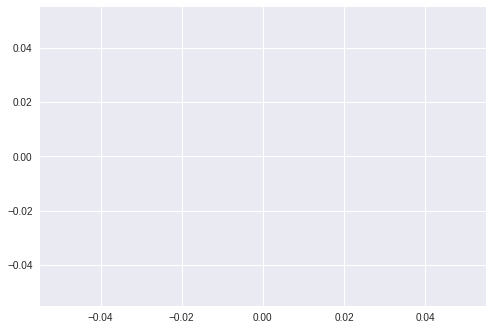

In [58]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
# predict probabilities
probs = rf.predict_proba(test_features)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate AUC
# auc = roc_auc_score(test_labels, probs)
# print('AUC: %.3f' % auc)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels, probs, pos_label=2)

# plot no skill
# plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')

# show the plot
plt.show()

In [54]:
fpr

array([0.00000000e+00, 3.03030303e-04, 8.78787879e-03, 9.39393939e-03,
       9.69696970e-03, 1.03030303e-02, 1.09090909e-02, 1.21212121e-02,
       1.42424242e-02, 1.51515152e-02, 1.69696970e-02, 1.78787879e-02,
       1.84848485e-02, 1.93939394e-02, 1.96969697e-02, 2.03030303e-02,
       2.09090909e-02, 2.15151515e-02, 2.39393939e-02, 2.45454545e-02,
       2.48484848e-02, 2.54545455e-02, 2.57575758e-02, 2.69696970e-02,
       2.87878788e-02, 3.00000000e-02, 3.06060606e-02, 3.09090909e-02,
       3.18181818e-02, 3.27272727e-02, 3.36363636e-02, 3.42424242e-02,
       3.51515152e-02, 3.63636364e-02, 3.69696970e-02, 3.75757576e-02,
       3.78787879e-02, 3.84848485e-02, 3.87878788e-02, 4.03030303e-02,
       4.09090909e-02, 4.21212121e-02, 4.27272727e-02, 4.36363636e-02,
       4.39393939e-02, 4.57575758e-02, 4.69696970e-02, 4.75757576e-02,
       4.84848485e-02, 5.00000000e-02, 5.06060606e-02, 5.15151515e-02,
       5.39393939e-02, 5.45454545e-02, 5.51515152e-02, 5.54545455e-02,
      